In [3]:
#ライブラリのimport
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import time
import shutil
import shap
import locale
import seaborn as sns
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from datetime import datetime
from PIL import Image

/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', co

In [98]:
import pandas as pd

def process_kanbandata_by_hour(file_path, datetime_column, order_quantity_column, start_date=None, end_date=None):
    
    # CSVファイルの読み込み
    data = pd.read_csv(file_path, encoding='shift_jis')

    # 日時カラムを datetime 形式に変換
    data[datetime_column] = pd.to_datetime(data[datetime_column], errors='coerce')

    # 品番ごとに1時間ごとの発注かんばん数を集計
    data['1時間単位時刻'] = data[datetime_column].dt.floor('H')
    hourly_orders = data.groupby(['品番', '1時間単位時刻']).size().reset_index(name=order_quantity_column)

    # 1時間前から22時間前の発注かんばん数を計算するループ
    for i in range(1, 23):
        hourly_orders[f'{i}時間前の{order_quantity_column}'] = hourly_orders.groupby('品番')[order_quantity_column].shift(i)

    # 全時間範囲のデータフレームを作成し、元の集計データとマージする
    #start_data、end_dateが定義されていれば、使用
    min_time = pd.to_datetime(start_date) if start_date else data[datetime_column].min()
    max_time = pd.to_datetime(end_date)   if end_date   else data[datetime_column].max()
    all_times = pd.date_range(start=min_time.floor('H'), end=max_time.ceil('H'), freq='H')

    # 品番ごとに全時間範囲のデータフレームを作成し、元の集計データとマージする
    product_time_combinations = pd.MultiIndex.from_product([data['品番'].unique(), all_times], names=['品番', '1時間単位時刻'])
    full_data = pd.DataFrame(index=product_time_combinations).reset_index()
    full_data = full_data.merge(hourly_orders, on=['品番', '1時間単位時刻'], how='left')
    full_data.fillna(0, inplace=True)  # 一括でNaNを0に変換
    for i in range(1, 23):
        full_data[f'{i}時間前の{order_quantity_column}'] = full_data.groupby('品番')[order_quantity_column].shift(i)

    return full_data

# 使用例
file_path = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済.csv'
datetime_column = '発注日時'
order_quantity_column = '発注かんばん数'
hatyu_data = process_kanbandata_by_hour(file_path, datetime_column, order_quantity_column,'2023-09-28','2024-04-10')

file_path = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済.csv'
datetime_column = '検収日時'
order_quantity_column = '納入かんばん数'
nonyu_data = process_kanbandata_by_hour(file_path, datetime_column, order_quantity_column,'2023-09-28','2024-04-10')

merged_data = pd.merge(hatyu_data, nonyu_data, on=['品番','1時間単位時刻'], how='left')

# 統合したデータを新しいCSVファイルに保存
with open('発注納入データ.csv', mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    nonyu_data.to_csv(f)

#サンプルデータ
merged_data[merged_data['品番'] == '019128GA010    '].head(50)

,品番,1時間単位時刻,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,13時間前の納入かんばん数,14時間前の納入かんばん数,15時間前の納入かんばん数,16時間前の納入かんばん数,17時間前の納入かんばん数,18時間前の納入かんばん数,19時間前の納入かんばん数,20時間前の納入かんばん数,21時間前の納入かんばん数,22時間前の納入かんばん数
102982,019128GA010,2023-09-28 00:00:00,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102983,019128GA010,2023-09-28 01:00:00,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102984,019128GA010,2023-09-28 02:00:00,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102985,019128GA010,2023-09-28 03:00:00,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102986,019128GA010,2023-09-28 04:00:00,0.0,0.0,0.0,0.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102987,019128GA010,2023-09-28 05:00:00,0.0,0.0,0.0,0.0,0.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102988,019128GA010,2023-09-28 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102989,019128GA010,2023-09-28 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102990,019128GA010,2023-09-28 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102991,019128GA010,2023-09-28 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
filtered_merged_data = merged_data[(merged_data['品番'] == '019128GA010    ')&(merged_data['納入かんばん数'] != 0)]
filtered_merged_data = merged_data[(merged_data['品番'] == '82824ECE010    ')&(merged_data['納入かんばん数'] != 0)]
unique_values = filtered_merged_data['1時間単位時刻'].dt.time.unique()
# 結果を表示
unique_values = filtered_merged_data['納入かんばん数'].unique()
print(unique_values)

filtered_merged_data = merged_data[(merged_data['品番'] == '82824ECE010    ')&(merged_data['発注かんばん数'] != 0)]
unique_values = filtered_merged_data['1時間単位時刻'].dt.time.unique()
unique_values = filtered_merged_data['発注かんばん数'].unique()
# 結果を表示
print(unique_values)

[13. 10. 11. 12.  9.  8.  5.  4.  7.  6.]
[10. 11. 12. 13.  9.  8.  5.  4.  7.  6.]


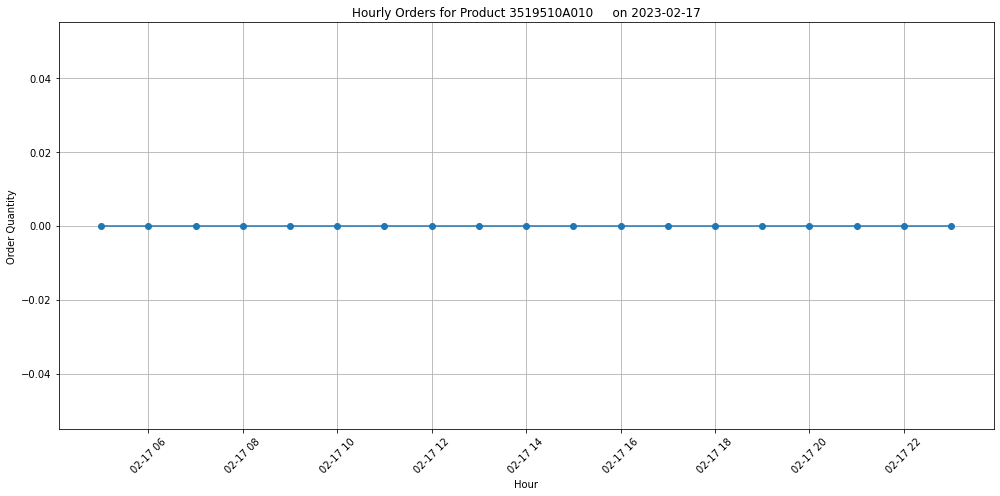

('3519510A010    ', datetime.date(2023, 2, 17))

In [47]:
import matplotlib.pyplot as plt

# データフレームからランダムに品番を一つ選ぶ
random_product = full_data['品番'].sample(1).iloc[0]

# その品番の最初の日を選ぶ
random_date = full_data[full_data['品番'] == random_product]['1時間単位時刻'].dt.date.iloc[0]

# 特定の品番の特定の日のデータを選択
specific_data = full_data[(full_data['品番'] == random_product) & (full_data['1時間単位時刻'].dt.date == random_date)]

# プロット
plt.figure(figsize=(14, 7))
plt.plot(specific_data['1時間単位時刻'], specific_data['発注かんばん数'], marker='o', linestyle='-')
plt.title(f'Hourly Orders for Product {random_product} on {random_date}')
plt.xlabel('Hour')
plt.ylabel('Order Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 選択した品番と日付を出力
random_product, random_date


In [112]:
# CSVファイルの読み込み
file_path = '中間成果物/在庫推移MBデータ_統合済.csv'
zaikodata = pd.read_csv(file_path, encoding='shift_jis')
zaikodata['在庫増減数']=zaikodata["入庫数（箱）"]-zaikodata["出庫数（箱）"]
# 不要な「Unnamed」列を削除                
zaikodata = zaikodata.loc[:, ~zaikodata.columns.str.contains('^Unnamed')]
zaikodata.head(100)

#列名の変更
zaikodata = zaikodata.rename(columns={'計測日時': '1時間単位時刻'})
zaikodata['1時間単位時刻'] = pd.to_datetime(zaikodata['1時間単位時刻'], errors='coerce')

filtered_zaikodata = zaikodata[(zaikodata['品番'] == '82824ECE010    ')&(zaikodata['入庫数（箱）'] != 0)]
unique_values = filtered_zaikodata['1時間単位時刻'].dt.time.unique()
# 結果を表示
print(unique_values)

merged_data2 = pd.merge(merged_data, zaikodata, on=['品番','1時間単位時刻'], how='left')
merged_data2[merged_data2['品番'] == '019128GA010    '].head(24)

[datetime.time(15, 0) datetime.time(16, 0) datetime.time(17, 0)
 datetime.time(18, 0) datetime.time(3, 0) datetime.time(1, 0)]


,品番,1時間単位時刻,発注かんばん数,1時間前の発注かんばん数,2時間前の発注かんばん数,3時間前の発注かんばん数,4時間前の発注かんばん数,5時間前の発注かんばん数,6時間前の発注かんばん数,7時間前の発注かんばん数,...,18時間前の納入かんばん数,19時間前の納入かんばん数,20時間前の納入かんばん数,21時間前の納入かんばん数,22時間前の納入かんばん数,拠点所番地,在庫数（箱）,入庫数（箱）,出庫数（箱）,在庫増減数
102982,019128GA010,2023-09-28 00:00:00,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102983,019128GA010,2023-09-28 01:00:00,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102984,019128GA010,2023-09-28 02:00:00,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102985,019128GA010,2023-09-28 03:00:00,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102986,019128GA010,2023-09-28 04:00:00,0.0,0.0,0.0,0.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102987,019128GA010,2023-09-28 05:00:00,0.0,0.0,0.0,0.0,0.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102988,019128GA010,2023-09-28 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102989,019128GA010,2023-09-28 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102990,019128GA010,2023-09-28 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102991,019128GA010,2023-09-28 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
file_path = '組立生産台数.csv'
kumitate_data = pd.read_csv(file_path, encoding='shift_jis')
kumitate_data.head(10)
unique_values = kumitate_data['JIKANWARI_KBN'].unique()
# 結果を表示
print(unique_values)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [97]:
file_path = '定期便.csv'
teiki_data = pd.read_csv(file_path, encoding='shift_jis')
# 日時の列を datetime 型に変換
teiki_data['JISEKI_DT'] = pd.to_datetime(teiki_data['JISEKI_DT'])
teiki_data['JISEKI_DT2'] = pd.to_datetime(teiki_data['JISEKI_DT2'])
teiki_data['JISEKI_DT（1H）'] = pd.to_datetime(teiki_data['JISEKI_DT']).dt.floor('H')
teiki_data['JISEKI_DT2（1H）'] = pd.to_datetime(teiki_data['JISEKI_DT2']).dt.floor('H')

#荷役時間数時間とかある

# 日時の差を計算
teiki_data["荷役時間"] = teiki_data['JISEKI_DT2'] - teiki_data['JISEKI_DT']
teiki_data.head(20)

unique_values = teiki_data['JISEKI_DT（1H）'].dt.time.unique()
# 結果を表示
print(unique_values)

[datetime.time(9, 0) datetime.time(13, 0) datetime.time(17, 0)
 datetime.time(21, 0) datetime.time(1, 0) datetime.time(5, 0)
 datetime.time(14, 0) datetime.time(4, 0) datetime.time(16, 0)
 datetime.time(18, 0) datetime.time(2, 0)]


In [ ]:
G9210ECC010


In [81]:
print(merged_data['1時間単位時刻'].dtype)
print(zaikodata['1時間単位時刻'].dtype)


datetime64[ns]
object
